[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/vision-transformers/vit.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/vision-transformers/vit.ipynb)

# Vision Transformers (ViT) Walkthrough

In [ ]:
!pip install datasets torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from torchvision import transforms
from keras.utils import to_categorical
from PIL import Image
from matplotlib import cm
from datasets import load_dataset
from io import BytesIO

import cv2

In [ ]:
from datasets import Dataset
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/fer2013-banlence.csv'
data = pd.read_csv(data_path)
data.head(5)

,emotion,pixels,Usage
0,1,44 50 65 83 92 100 109 124 134 140 141 145 145...,PrivateTest
1,4,65 59 52 57 75 85 110 117 117 121 132 139 143 ...,PrivateTest
2,5,251 251 251 250 250 252 252 252 253 252 252 25...,PrivateTest
3,3,26 27 27 31 33 36 40 38 35 36 38 43 48 54 61 6...,PrivateTest
4,2,246 246 247 247 222 212 196 186 210 220 207 19...,PrivateTest


In [ ]:
data[data['Usage'] == 'PublicTest'].count

<bound method DataFrame.count of        emotion                                             pixels       Usage
7176         5  255 255 255 253 255 228 121 101 70 58 55 60 10...  PublicTest
7177         5  238 237 235 237 231 229 225 175 100 110 89 98 ...  PublicTest
7178         6  58 48 33 23 19 84 230 251 216 178 146 112 91 8...  PublicTest
7179         1  2 3 3 3 3 4 5 2 2 3 3 2 4 4 4 4 4 8 3 2 5 0 15...  PublicTest
7180         4  120 63 107 138 138 119 156 191 212 180 172 154...  PublicTest
...        ...                                                ...         ...
12913        6  39 39 37 54 37 29 30 20 20 17 21 21 18 17 15 1...  PublicTest
12914        6  229 230 231 232 233 234 236 236 236 237 236 24...  PublicTest
12915        0  251 250 254 230 124 104 138 129 158 159 99 91 ...  PublicTest
12916        3  56 46 44 38 32 41 45 42 37 30 26 27 33 48 60 8...  PublicTest
12917        2  119 106 101 50 77 162 191 167 154 130 115 109 ...  PublicTest

[5742 rows x 3 columns]>

In [ ]:
digit_img = np.uint8([item.split() for item in data['pixels']]).reshape(data['pixels'].shape[0], 48, 48, 1)


In [ ]:
def cvIMGRGB(batch):
  dest = []
  for img in batch:
    buffer = BytesIO()
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = Image.fromarray(img, mode='RGB')
    img.save(buffer, format='PNG')
    png_image = Image.open(buffer)
    dest.append(png_image)
  return dest

In [ ]:
data['image'] = cvIMGRGB(digit_img[:])

In [ ]:
data = data.drop('pixels', axis=1)

In [ ]:
emotions = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral"
    }

In [ ]:
df_train = data[data['Usage'] == 'Training']
df_train = pd.concat([df_train, data[data['Usage'] == 'PublicTest']], ignore_index = True) 
df_test = data[data['Usage'] == 'PrivateTest']

In [ ]:
df_train.count

<bound method DataFrame.count of        emotion       Usage                                              image
0            4    Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
1            2    Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
2            1    Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
3            2    Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
4            1    Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
...        ...         ...                                                ...
28701        6  PublicTest  <PIL.PngImagePlugin.PngImageFile image mode=RG...
28702        6  PublicTest  <PIL.PngImagePlugin.PngImageFile image mode=RG...
28703        0  PublicTest  <PIL.PngImagePlugin.PngImageFile image mode=RG...
28704        3  PublicTest  <PIL.PngImagePlugin.PngImageFile image mode=RG...
28705        2  PublicTest  <PIL.PngImagePlugin.PngImageFile image mode=RG...

[28706 rows x 3 columns]>

In [ ]:
data[data['Usage'] == 'Training'].count

<bound method DataFrame.count of        emotion     Usage                                              image
12918        4  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
12919        2  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
12920        1  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
12921        2  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
12922        1  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
...        ...       ...                                                ...
35877        0  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
35878        1  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
35879        3  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
35880        4  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...
35881        1  Training  <PIL.PngImagePlugin.PngImageFile image mode=RG...

[22964 rows x 3 columns]>

In [ ]:
dataset_train = Dataset.from_dict({'image' : df_train['image'], 'emotion' : df_train['emotion']})
dataset_test = Dataset.from_dict({'image' : df_test['image'], 'emotion' : df_test['emotion']})

In [ ]:
num_classes = len(set(dataset_train['emotion']))
labels = dataset_train.features['emotion']
num_classes, labels

(7, Value(dtype='int64', id=None))

### Loading ViT Feature Extractor

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.1 MB/s eta 0:00:00


We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [ ]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


You can see the feature extractor configuration by printing it

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

If we consider the first image, i.e., the airplane shown above, we can see the resulting tensor after passing the image through the feature extractor. 

In [ ]:
example = feature_extractor(
    dataset_train[1]['image'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[ 0.8745,  0.8745,  0.8745,  ...,  0.5529,  0.5922,  0.5922],
          [ 0.8745,  0.8745,  0.8745,  ...,  0.5529,  0.5922,  0.5922],
          [ 0.8745,  0.8745,  0.8745,  ...,  0.5216,  0.5608,  0.5608],
          ...,
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1216, -0.1294, -0.1294],
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1373, -0.1451, -0.1451],
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1373, -0.1451, -0.1451]],

         [[ 0.8745,  0.8745,  0.8745,  ...,  0.5529,  0.5922,  0.5922],
          [ 0.8745,  0.8745,  0.8745,  ...,  0.5529,  0.5922,  0.5922],
          [ 0.8745,  0.8745,  0.8745,  ...,  0.5216,  0.5608,  0.5608],
          ...,
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1216, -0.1294, -0.1294],
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1373, -0.1451, -0.1451],
          [ 0.7333,  0.7333,  0.7333,  ..., -0.1373, -0.1451, -0.1451]],

         [[ 0.8745,  0.8745,  0.8745,  ...,  0.5529,  0.5922,  0.5922],
          [ 0

In [ ]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [ ]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['emotion']
    return inputs

In [ ]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [ ]:
prepared_train

Dataset({
    features: ['image', 'emotion'],
    num_rows: 28706
})

We can apply this to both the training and testing dataset.

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*. 

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)). 

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [ ]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-27-b7bbca42f0bd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./customA",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=6,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [ ]:
from transformers import ViTForImageClassification

# labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=7
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

We can save our trained model.

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.400200,1.361656,0.488852
200,1.433500,1.272129,0.537625
300,1.263400,1.205773,0.548774
400,1.106100,1.195326,0.559504
500,0.850800,1.172110,0.560340
600,0.975900,1.113547,0.589604
700,1.042900,1.061691,0.617893
800,0.962500,1.101629,0.601867
900,1.091300,1.011506,0.619983
1000,1.137400,1.142786,0.567865


In [ ]:
# save tokenizer with the model
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/nhapmonthigiacmaytinh')
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

***** train metrics *****
  epoch                    =           6.0
  total_flos               = 12430835928GF
  train_loss               =        0.4677
  train_runtime            =    4:49:20.52
  train_samples_per_second =         9.921
  train_steps_per_second   =          0.62


In [ ]:
pt_save_directory = "/content/drive/MyDrive/Colab Notebooks/nhapmonthigiacmaytinh"
feature_extractor.save_pretrained(pt_save_directory)
model.save_pretrained(pt_save_directory)

#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [ ]:
metrics = trainer.evaluate(prepared_train)
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

***** train metrics *****
  epoch                   =        6.0
  eval_accuracy           =     0.8979
  eval_loss               =     0.3238
  eval_runtime            = 0:06:27.66
  eval_samples_per_second =     74.048
  eval_steps_per_second   =      9.258


In [ ]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("val", metrics)
trainer.save_metrics("val", metrics)

***** val metrics *****
  epoch                   =        6.0
  eval_accuracy           =     0.7486
  eval_loss               =     0.7378
  eval_runtime            = 0:01:36.36
  eval_samples_per_second =     74.464
  eval_steps_per_second   =      9.308


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

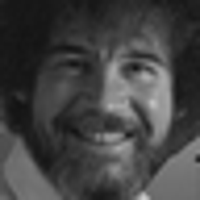

In [ ]:
# show the first image of the testing dataset
image = dataset_test["image"][8].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [ ]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["emotion"][8]

actual_label, emotions[actual_label]


(3, 'Happy')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = 'LaCarnevali/vit-cifar10'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [ ]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['emotion']
emotions[predicted_label]

'Happy'

## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.